<a href="https://colab.research.google.com/github/darkwings/ai-notebooks/blob/main/The_Researcher_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Researcher (version 1)

This notebook implements a simple search workflow targeted to the composition of an *essay* about a specific topic, with critique functionalities to drive the review of the essay.

This is the first version, based on web search performed by Tavily.

## What's next

Next versions of the researcher will include

- parallel search and aggregation of results
- access to local documents with Vector Store (Self RAG)


## Let's do it

The implementation is based on [LangGraph](https://www.langchain.com/langgraph)

Let's start with the setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


Now, let's import all the needed stuff and declare

- the main [state](https://medium.com/@gitmaxd/understanding-state-in-langgraph-a-comprehensive-guide-191462220997) of the Graph
- some objects that we're going to use as [structured output](https://python.langchain.com/docs/concepts/structured_outputs/)

In [16]:
from typing import TypedDict, List
from langchain_openai import ChatOpenAI
import operator
from pydantic import BaseModel, Field
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class AgentState(TypedDict):
  # the topic of the essay
  topic: str

  #the plan
  plan: str

  # the content written by the compose agent
  draft: str

  # the desired language
  desired_language: str

  # the critique moved by reflection step
  critique: str

  # the body of collected documents
  content: List[str]

  # the iteration
  revision_number: int

  # the max number of iterations
  max_revisions: int


# STRUCTURED OUTPUTS
class Plan(BaseModel):
  plan: str

class Queries(BaseModel):
  queries: List[str]

## Nodes

Now, let's define the nodes

In [17]:
llm = ChatOpenAI(model="gpt-4o")
tavily_search = TavilySearchResults(max_results=3)

In [18]:
# PLAN SEARCH NODE
def plan_node(state: AgentState):
  system_prompt = """
  You're a helpful assistant that can determine, starting from a topic described with simple words,
  a full plan that can be used to reason about the given topic. If you don't know
  anything about the topic, please create a plan that will give you all
  the needed kwowledge about the topic
  """
  messages = [
      SystemMessage(content=system_prompt),
      HumanMessage(content=f"Generate a plan to generate an essay about the following topic: {state['topic']}")
  ]
  plan = llm.with_structured_output(Plan).invoke(messages)
  return {"plan": plan.plan}


# RESEARCH NODE
def research_node(state: AgentState):
  system_prompt = """
  You are a researcher that is in charge, given a plan, to provide meaningful information to write an essay.
  Given a plan, you're in charge to produce 3 meaningful search queries that can be
  used to search the web in order to gather meaningful informations.

  The plan is the following:
  {plan}
  """

  queries = llm.with_structured_output(Queries).invoke(
      [SystemMessage(content=system_prompt.format(plan=state["plan"])),
       HumanMessage(content="Generate 3 search queries based on the plan.")]
  )
  content = state['content'] or []
  for q in queries.queries:
    documents = tavily_search.invoke({"query": q})
    for doc in documents:
      content.append(f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>')
  return {"content": content}


# GENERATE ESSAY NODE
def generate_node(state: AgentState):
  system_prompt = """
  You're an expert in writing an essay of 5 paragraph given the provided
  information. Try to adhere to the target topic and the provided plan. Your
  output should be captivating and should be understandable by non expert people,
  so try to use the simplest words possible to keep the essay understandable.

  Your output should be in markdown format, it must have a captivating titles
  and each paragraph should have a meaningful header outlining the content of
  the paragraph itself.

  This is the content to use for the essay. It is expressed as XML tag, with
  the document tag containing the URL. Add a final section in the essay adding the
  url of the documents used to generate the essay.

  Important: the essay should be written in the following language: {desired_language}

  -------

  {content}
  """
  content = "\n\n".join(state['content'] or [])
  messages = [
      SystemMessage(content=system_prompt.format(desired_language=state['desired_language'], content=content)),
      HumanMessage(content=f"This is the topic to discuss: {state['topic']}.\n\nThis is the plan: {state['plan']}")
  ]
  draft = llm.invoke(messages)
  return {"draft": draft.content, "revision_number": state.get('revision_number', 1) + 1}


# REFLECTION NODE
def reflection_node(state: AgentState):
  system_prompt = """
  You're a helpful reviewer in order to understand if the provided draft is consistent
  with the given plan and topic and if the draft is understandable by non expert people.

  The outcome of your analysis should be a critique that can be used to improve the draft
  and further search the web to improve sources.

  If the draft is ok just output the word "OK", that means there are no critiques.

  -------

  This is the initial topic: {topic}

  This is the plan: {plan}

  This is the draft of the essay:
  {draft}
  """

  topic = state.get('topic', '')  # Get 'topic' with a default value if not present
  plan = state.get('plan', '')  # Get 'plan' with a default value if not present
  draft = state.get('draft', '')

  critique = llm.invoke([SystemMessage(content=system_prompt.format(topic=topic, plan=plan, draft=draft))])
  return {"critique": critique.content}


# CRITIQUE NODE
def research_critique_node(state: AgentState):
  system_prompt = """
  You're a smart reviewer and you're able to generare a search query to
  satisfy a critique that is proposed about the given draft.

  This is the draft of the essay:
  {draft}
  """
  messages = [
      SystemMessage(content=system_prompt.format(draft=state['draft'])),
      HumanMessage(content=f"Generate 3 search queries based on the following critique: {state['critique']}")
  ]
  queries = llm.with_structured_output(Queries).invoke(messages)
  content = state['content'] or []
  for q in queries.queries:
    documents = tavily_search.invoke(q)
    for doc in documents:
      content.append(f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>')
  return {"content": content}


# LOOPER
def should_continue(state: AgentState):
  if state["critique"] == "OK":
    return END
  if state["revision_number"] > state["max_revisions"]:
    return END
  return "reviewer"

Now we can compose the graph


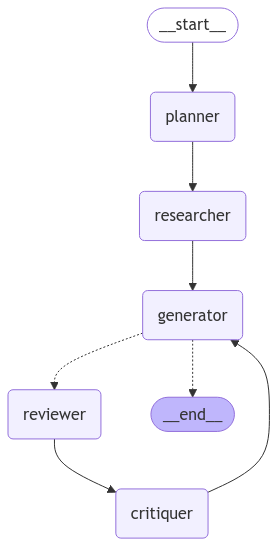

In [19]:
builder = StateGraph(AgentState)

builder.add_node("planner", plan_node)
builder.add_node("researcher", research_node)
builder.add_node("generator", generate_node)
builder.add_node("reviewer", reflection_node)
builder.add_node("critiquer", research_critique_node)

builder.set_entry_point("planner")

builder.add_conditional_edges("generator",
                              should_continue,
                              {END: END, "reviewer": "reviewer"})

builder.add_edge("planner", "researcher")
builder.add_edge("researcher", "generator")
builder.add_edge("reviewer", "critiquer")
builder.add_edge("critiquer", "generator")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

As we can see, the first version of the Researcher is very basic. It always performs 3 round of critique and does not allow parallel research. Moreover, it relies only on web documents.

We will address those issues in the next versions.

## Test

Ora passiamo al test del grafo

In [21]:
from IPython.display import Markdown

state = AgentState(topic="descrivi storia e funzionamento del motore a due tempi",
                   plan="",
                   desired_language="italian",
                   draft="",
                   critique="",
                   content=[],
                   revision_number = 0,
                   max_revisions=2)

configurable = {"configurable": {"thread_id": "1"}}

graph.invoke(input=state, config=configurable)

result = graph.get_state(configurable)

# print(result)

# result is a tuple
Markdown(result.values["draft"])



# Il Fascino dei Motori a Due Tempi: Storia e Funzionamento

## Introduzione ai Motori a Due Tempi

I motori a due tempi rappresentano una pietra miliare nel mondo della meccanica. Si tratta di motori a combustione interna che completano un ciclo di potenza con soli due movimenti del pistone, rendendoli fondamentali per applicazioni dove la leggerezza e la semplicità sono essenziali. Questi motori hanno trovato un posto speciale nei cuori degli appassionati di motori per la loro capacità di fornire grande potenza su macchine più piccole e leggere.

## La Storia del Motore a Due Tempi

Il motore a due tempi ha origini che risalgono al 1880, con l'invenzione attribuita a Dugald Clark. Successivamente, Joseph Day migliorò il design con un brevetto nel 1895, introducendo un motore a due tempi con due porte. Nel corso degli anni, questi motori hanno subito varie trasformazioni, trovando applicazione in settori come quello agricolo, motociclistico e nelle attrezzature portatili. La loro semplicità di costruzione e manutenzione li ha resi ideali per utilizzi dove la robustezza e l'affidabilità erano richieste.

## Principio di Funzionamento del Motore a Due Tempi

Un motore a due tempi si compone principalmente di un pistone, un cilindro e una biella. Nel suo ciclo di funzionamento, il motore esegue quattro fasi principali: aspirazione, compressione, scoppio e scarico, il tutto in due soli movimenti del pistone. A differenza dei motori a quattro tempi, i motori a due tempi non utilizzano valvole per il controllo dei gas, ma porte nel cilindro che si aprono e chiudono con il movimento del pistone, rendendo il ciclo più rapido e semplice.

## Vantaggi e Svantaggi del Motore a Due Tempi

I motori a due tempi offrono vantaggi significativi, tra cui peso ridotto e meno componenti mobili, il che si traduce in costi di produzione e manutenzione inferiori. Tuttavia, presentano anche svantaggi, come un'efficienza del carburante più bassa e maggiori emissioni inquinanti rispetto ai motori a quattro tempi. Questi aspetti li hanno resi meno popolari nelle applicazioni dove le normative ambientali sono stringenti.

## Utilizzo Moderno e Prospettive Future

Oggi, i motori a due tempi sono ancora utilizzati in settori come quello delle attrezzature da giardinaggio, motociclette leggere e motori fuoribordo. Le recenti innovazioni, come l'iniezione diretta, hanno migliorato l'efficienza e ridotto le emissioni, aprendo nuove prospettive per questi motori. Nonostante la crescente diffusione dei motori elettrici, i motori a due tempi continuano ad avere un ruolo nelle applicazioni dove la potenza immediata e il peso ridotto sono essenziali.

## Conclusione

In sintesi, i motori a due tempi hanno una storia ricca e complessa, con un funzionamento semplice ma efficace. Nonostante i loro limiti, continuano a essere una scelta valida in diverse applicazioni grazie alle loro caratteristiche uniche. Con le innovazioni tecnologiche, potrebbero ancora avere un ruolo significativo nel futuro, bilanciando le sfide ambientali con il loro potenziale di alta potenza e leggerezza.

---

### Fonti Consultate

1. [The Early History of Engines | Actforlibraries.org](http://www.actforlibraries.org/the-early-history-of-engines/)
2. [Two-stroke diesel engine - Wikipedia](https://en.wikipedia.org/wiki/Two-stroke_diesel_engine)
3. [The 2-Stroke Cycle - Gas Engine Magazine](https://www.gasenginemagazine.com/gas-engines/2-stroke-cycle-zm0z19djzhur/)
4. [Two-stroke engine - Byju's](https://byjus.com/physics/two-stroke-engine/)
5. [Two-stroke engine - Testbook](https://testbook.com/physics/two-stroke-engine)